In [1]:
import numpy as np
import random
import cv2
import glob
import os
import shutil
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import leidenalg as la
from sklearn.metrics.cluster import adjusted_rand_score
from tiatoolbox.tools.stainnorm import MacenkoNormalizer
import keras
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet

|2025-06-04|13:32:51.843| [WARNING] /home/hrawei/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

2025-06-04 13:32:54.889161: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-04 13:32:54.932225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-04 13:32:55.708537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38]

In [2]:
def getBaseModel():
    
    baseModel = MobileNet(weights="imagenet", include_top=False, input_shape=(224,224, 3))
    output = keras.layers.GlobalAveragePooling2D()(baseModel.output)
    model = keras.models.Model(inputs=[baseModel.input], outputs=[output])
    preprocessFun = preprocess_input_mobilenet
    
    return model, preprocessFun

def maskBackground(img,mask,color):
    
    # Convert mask to binary
    imgray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(imgray, 127, 255, 0)

    # Replace area outside of mask with predefined color
    img_masked=np.ones((img.shape[0],img.shape[1],3),dtype=img.dtype)*color
    img_masked[thresh==255]=img[thresh==255]

    return(img_masked)

def normalizePatches(inputFolder,outputFolder,refImage,refBase):

    # Get reference image
    ref = np.array(Image.open(refImage))[:,:,:3]

    # Create output directory for class
    if os.path.exists(outputFolder+refBase):
        shutil.rmtree(outputFolder+refBase)
    os.mkdir(outputFolder+refBase)
    
    # Setup the Macenko normalizer
    normalizer = MacenkoNormalizer()
    normalizer.fit(ref)

    # Get class names from folders
    classes = [os.path.basename(d) for d in glob.glob(inputFolder+'Images/*')]

    for cl in classes:

        # Get all raw images for the current class
        files = glob.glob(inputFolder+'/Images/'+cl+'/*.png')

        # Stain normalize each image
        for j in range(len(files)):

            # Get input and output paths for current image
            inFile = files[j]
            outFile = outputFolder+refBase+'/'+cl+'-'+str(j)+'.png'
            
            # Load image and mask
            img=np.array(Image.open(inFile))[:,:,:3]
            mask=np.array(Image.open(inFile.replace('Images/'+cl,'Masks')))[:,:,:3]

            # Normalize image
            normalized = normalizer.transform(img)
            
            # Remove background
            masked = maskBackground(normalized, mask,[0,0,0])

            # Save image
            Image.fromarray(masked.astype('uint8'), 'RGB').save(outFile)

def extractfeatures(inputFolder,classes,refBase):    
    
    # Get names of all images
    images = glob.glob(inputFolder+'*.png')

    # Load data and class labels
    data = np.zeros((len(images),224,224,3), dtype='uint8')
    labels = np.zeros((len(images),1), dtype='uint8')
    
    for i in range(len(images)):
        print(i, end='\r')
        data[i,:,:,:] = np.array(Image.open(images[i]))
        imgName = os.path.basename(images[i])
        className = imgName.split('-')[0]
        labels[i] = classes[className]

    # Get model and respective preprocess_input function
    model, preprocessInput = getBaseModel()
    
    # Preprocess data
    pData = preprocessInput(data)

    # Extract features
    feature_vector = model.predict(pData, batch_size=1, verbose=1)

    np.save(refBase+'-features.npy',feature_vector)
    np.save(refBase+'-names.npy',images)
    np.save(refBase+'-classes.npy',labels) 

def runClustering(refBase,classDict,classColors,clusterColors):

    # Load features and fileNames
    features = np.load(refBase+'-features.npy')
    imgnames = np.load(refBase+'-names.npy',allow_pickle=True)
    classes = np.load(refBase+'-classes.npy',allow_pickle=True)

    # Get class labels and names
    classNames = [classDict[j[0]] for j in classes]
    classLabels = [j[0] for j in classes]
    
    # Prepare data for Leiden clustering
    adata = sc.AnnData(features)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)    
    sc.tl.umap(adata)
    
    # Perform Leiden clustering
    r = 0.070
    nClusters = 1
    while nClusters <2:
        r = r+0.005
        sc.tl.leiden(adata, resolution=r)
        nClusters = len(np.unique(list(adata.obs['leiden'].astype('int'))))
    clusters = list(adata.obs['leiden'].astype('int'))
    xy = adata.obsm['X_umap']

    details = {
        'x' : list(xy[:,0]),
        'y' : list(xy[:,1]),
        'clusters' : list(clusters),
        'classLabel' : list(classLabels),
        'className' : list(classNames),
        'imgNames' : list(imgnames)
    }
  
    # creating a Dataframe object 
    df = pd.DataFrame(details)
    df.to_csv(refBase+'-clustering.tsv',sep='\t')

    df['classColor'] = [classColors[i] for i in df['classLabel']]
    df['clusterColor'] = [clusterColors[i] for i in df['clusters']]
    
    return df

In [3]:
random.seed(1234)

# Which reference to use for stain normalization
refImage = './Patches/Raw/Images/nonGS/SAS_21883_001-0.png'
refBase, _ = os.path.splitext(os.path.basename(refImage))

# Stain normalize patches
normalizePatches('./Patches/Raw/','./Patches/Normalized/',refImage,refBase)      

# Extract all features
extractfeatures('./Patches/Normalized/'+refBase+'/',dict({'nonGS': 0, 'GS': 1}),refBase)

# Run the clustering
df = runClustering(refBase,dict({0: 'nonGS', 1: 'GS'}),['#83c5be','#006d77'],['#bcbddc','#756bb1'])           

945

2025-06-04 13:33:41.395506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1103 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:15:00.0, compute capability: 8.6
2025-06-04 13:33:41.396217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18223 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:21:00.0, compute capability: 8.6
2025-06-04 13:33:43.122169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-06-04 13:33:43.302317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


946/946 [==============================] - 5s 5ms/step


In [4]:
# Compute and print the adjusted rand index
print(adjusted_rand_score(df['classLabel'],df['clusters']))

0.8790622700757842


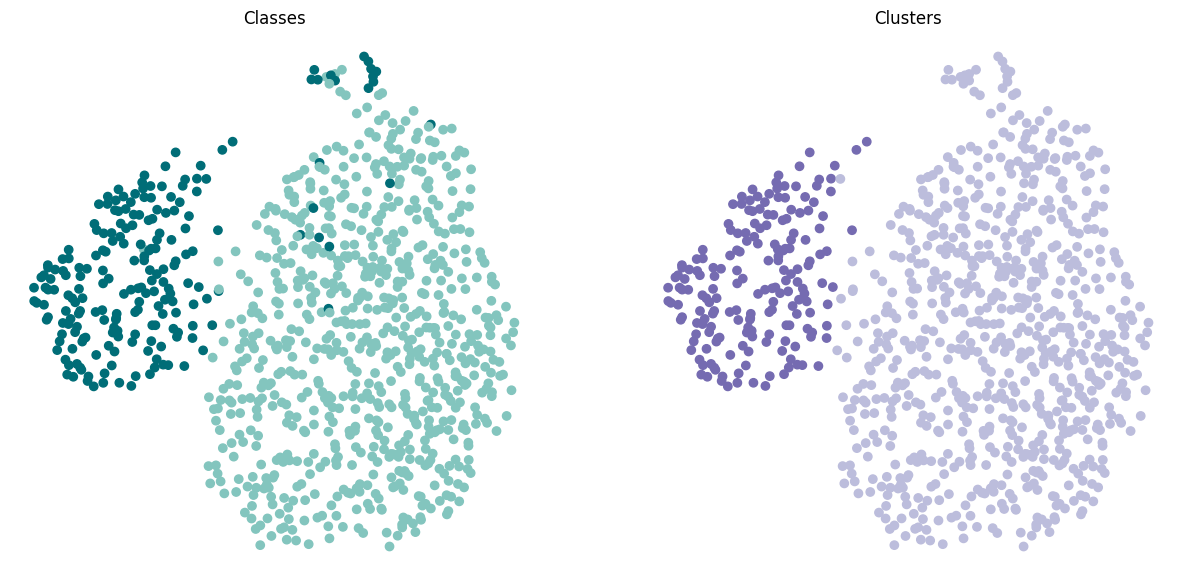

In [5]:
# Do some plotting 
fig= plt.figure(figsize=(15, 7))

ax=plt.subplot(1,2,1)
ax.scatter(df['x'],df['y'],c=df['classColor']) 
ax.set_title('Classes')
ax.axis('off');

ax=plt.subplot(1,2,2)
ax.scatter(df['x'],df['y'],c=df['clusterColor']) 
ax.set_title('Clusters')
ax.axis('off');